<a href="https://colab.research.google.com/github/FariaParvinMegha/deep_dive_NN/blob/main/micrograd%3F.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt
import torch
import random

# fundamental idea

In [ ]:
def f(x):
  return 3*x**2 - 4*x + 5

In [ ]:
f(3.0)

20.0

[-5.   -4.75 -4.5  -4.25 -4.   -3.75 -3.5  -3.25 -3.   -2.75 -2.5  -2.25
 -2.   -1.75 -1.5  -1.25 -1.   -0.75 -0.5  -0.25  0.    0.25  0.5   0.75
  1.    1.25  1.5   1.75  2.    2.25  2.5   2.75  3.    3.25  3.5   3.75
  4.    4.25  4.5   4.75]
[100.      91.6875  83.75    76.1875  69.      62.1875  55.75    49.6875
  44.      38.6875  33.75    29.1875  25.      21.1875  17.75    14.6875
  12.       9.6875   7.75     6.1875   5.       4.1875   3.75     3.6875
   4.       4.6875   5.75     7.1875   9.      11.1875  13.75    16.6875
  20.      23.6875  27.75    32.1875  37.      42.1875  47.75    53.6875]


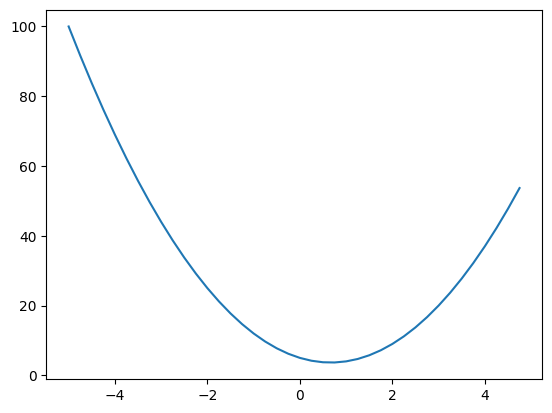

In [ ]:
xs = np.arange(-5, 5, 0.25)
print (xs)

ys = f(xs)
print(ys)

plt.plot(xs, ys)
plt.show()

In [ ]:
h = 0.00000001
x = 2/3
(f(x+h) - f(x))/h

0.0

a bit more complex

In [ ]:
h = 0.0001

# input
a = 2.0
b = -3.0
c = 10.0

d1 = a*b+c
c += h
d2 = a*b+c
print ('d1',d1)
print ('d2',d2)
print('slope', (d2-d1)/h)

d1 4.0
d2 4.0001
slope 0.9999999999976694


# main value class

In [ ]:
class value:

  def __init__(self, data, _children = (), _op = '', label = ''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None            #bakcpropegation function
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"value(data={self.data})"

  def __add__(self, other):
    other = other if isinstance(other, value) else value(other)         #so that 'a + 1' doesn't show typerror cz a is value object and 1 is integer
    out = value(self.data + other.data, (self, other), '+')

    def _backward():
      self.grad += out.grad
      other.grad += out.grad

    out._backward = _backward
    return out


  def __mul__(self, other):
    other = other if isinstance(other, value) else value(other)         #so that 'a * 1' doesn't show typerror cz a is value object and 1 is integer.
    out = value(self.data * other.data, (self, other), '*')

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad

    out._backward = _backward
    return out

  def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += other * (self.data**(other-1)) * out.grad
        out._backward = _backward

        return out

  def __truediv__(self, other): # self / other
        return self * other**-1     # a/b = a* 1/b = a * (b**-1)


  def __neg__(self): # Corrected: should only take self
    return value(-self.data, (self,), '-') # Return a new value object

  def __sub__(self, other):
    other = other if isinstance(other, value) else value(other) # Ensure other is a Value object for subtraction
    return self + (-other)

  def __rmul__(self, other):      #in case of other * self
    return self * other

  def __radd__(self, other): # in case of other + self
      return self + other # Utilize the existing __add__ method

  def tanh(self):                                 #activation function
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = value(t, (self, ), 'tanh')

    def _backward():
      self.grad += (1 - t**2) * out.grad

    out._backward = _backward
    return out

  def exp(self):
    x = self.data
    out = value(math.exp(x), (self, ), 'exp')

    def _backward():
      self.grad += out.data * out.grad      # derivative of exp(x) is exp(x)

    out._backward = _backward
    return out

  def backward(self):      #creating a master backward function so that u don't have to call bw for each node

    topo = []
    visited = set()
    def build_topo(v):
        if v not in visited:
            visited.add(v)
            for child in v._prev:
                build_topo(child)
            topo.append(v)
    build_topo(self)

    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

# creating graph

In [ ]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

# showing basic multiplication addition and gradient

In [ ]:
a = value(2.0, label= 'a')
b = value(-3.0, label= 'b')
c = value(10.0, label= 'c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = value(-2.0, label= 'f')
l = d * f; l.label = 'l'
l

value(data=-8.0)

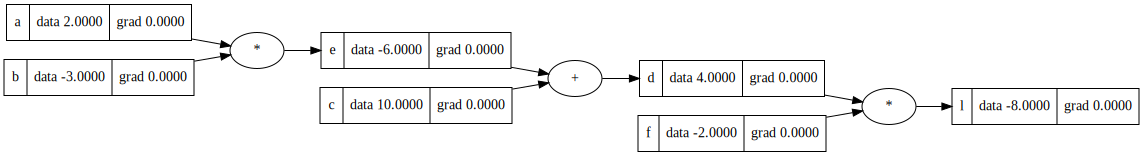

In [ ]:
draw_dot(l)

# Adding gradients

adding gradient to each of the nodes. basically doing backpropegation manually. means finding derivatioves of each of the node values with respect to "l". dl/dl, dl/dd, dl/df etc.

In [ ]:
### showing how derivatives/backpropegation works numerically/manually

def lol():

  h = 0.001

  a = value(2.0, label= 'a')
  b = value(-3.0, label= 'b')
  c = value(10.0, label= 'c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = value(-2.0, label= 'f')
  l = d * f; l.label = 'l'
  l1 = l.data

  a = value(2.0, label= 'a')
  b = value(-3.0, label= 'b')
  c = value(10.0, label= 'c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  # d.data += h
  f = value(-2.0, label= 'f')
  # f.data += h
  l = d * f; l.label = 'l'
  l2 = l.data+h

  print((l2-l1)/h)

lol()

1.000000000000334


In [ ]:
f.grad = 4.0    # dl/df = d
d.grad = -2.0   # dl/dd = f
l.grad = 1.0    # dl/dl = 1

In [ ]:
# dl/dc = f(gradient of d or leaf of c)
e.grad = -2.0
c.grad = -2.0

from the graph we see, 'plus' basically distributes the gradient of it's parent nodes eually to the leaf node. (assuming graph goes right to left)

In [ ]:
# dl/da = bf
# dl/db = af
a.grad = 6.0
b.grad = -4

In [ ]:
# now changing a,b,c to change l.
# to increase l, we need to increase it's leaf nodes to the direction of their gradient.
# basically a+h*a.grad something like that.

a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a * b
d = e + c
l = d * f

print (l.data)

-7.286496


# New Section
checking new functions

In [ ]:
a = value (2.0)
b = value (4.0)
a/b

value(data=0.5)

# A Two layer MLP
most basic example of what happens in a node of a NN

In [ ]:
# creating a single node of a neural net that takes two input

# input x1, x2
x1 = value(2.0, label = 'x1')
x2 = value(0.0, label = 'x2')
# weights
w1 = value(-3.0, label = 'w1')
w2 = value(1.0, label = 'w2')
# bias of the neuron
b = value(6.8813735870195432, label = 'b')

x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh() ; o.label = 'o'
o.backward ()

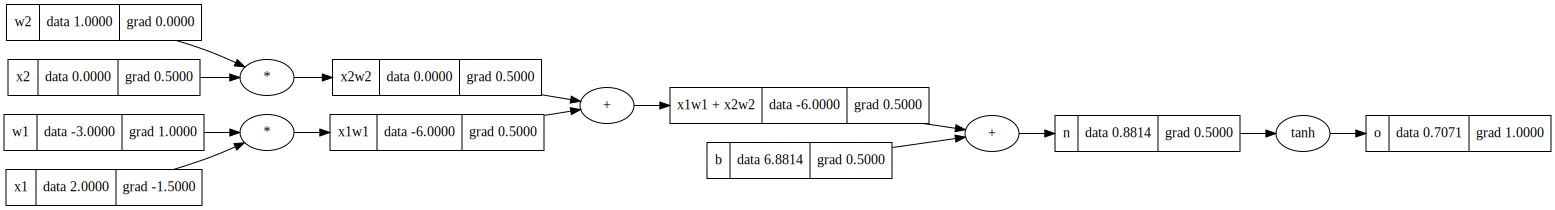

In [ ]:
draw_dot(o)

# manually calculating gradients for back propegaton

In [ ]:
# o = tanh (n)
# do/dn = 1 - o**2 (1 - tan squared h(n))
# 1 - o.data**2 = 0.5

n.grad = 0.5

In [ ]:
o.grad = 1.0

In [ ]:
b.grad = 0.5
x1w1x2w2.grad = 0.5

In [ ]:
x1w1.grad = 0.5
x2w2.grad = 0.5

In [ ]:
x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad

In [ ]:
x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad

In [ ]:
o.grad = 1.0      #cz in the function definition inital o.grad is set to 0.0. can't backrpopegate if that's 0. so manually setting it to 1.0

# calling backward for each node seperately

In [ ]:
o._backward ()

In [ ]:
n._backward ()

In [ ]:
x1w1x2w2._backward ()
b._backward ()      #nothing will happen cz b is a leaf node

In [ ]:
x1w1._backward ()
x2w2._backward ()

# calling backward only once using topological order

In [ ]:
# creating topological order
topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(o)
topo

[value(data=0.0),
 value(data=1.0),
 value(data=0.0),
 value(data=-3.0),
 value(data=2.0),
 value(data=-6.0),
 value(data=-6.0),
 value(data=6.881373587019543),
 value(data=0.8813735870195432),
 value(data=0.7071067811865476)]

In [ ]:
for node in reversed(topo):
    node._backward()

# calling master backward from class value



In [ ]:
o.backward()

fixing bugs

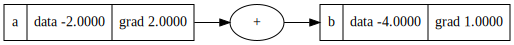

In [ ]:
a = value(-2.0, label = 'a')
b = a + a ; b.label = 'b'
b.backward()
draw_dot(b)

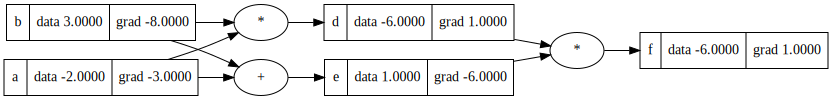

In [ ]:
a = value(-2.0, label = 'a')
b = value(3.0, label = 'b')
d = a*b ; d.label = 'd'
e = a+b ; e.label = 'e'
f = d*e ; f.label = 'f'

f.backward ()

draw_dot(f)

# more complex

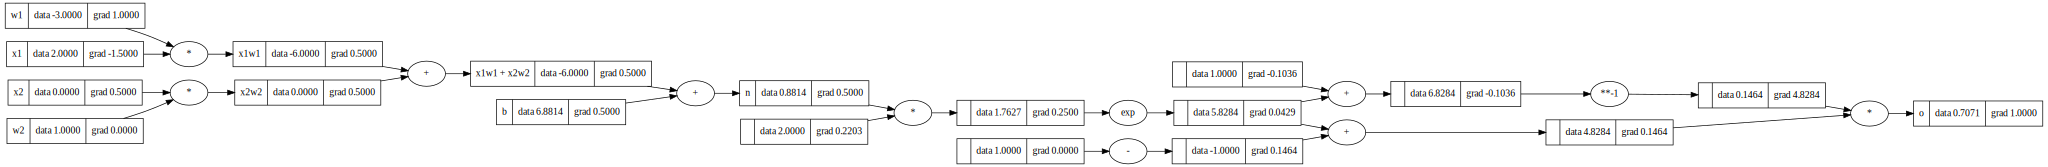

In [ ]:
# input x1, x2
x1 = value(2.0, label = 'x1')
x2 = value(0.0, label = 'x2')
# weights
w1 = value(-3.0, label = 'w1')
w2 = value(1.0, label = 'w2')
# bias of the neuron
b = value(6.8813735870195432, label = 'b')

x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'
##########
e = (2*n).exp()
o = (e - 1) / (e + 1)
##########
o.label = 'o'
o.backward ()
draw_dot(o)

# Using Pytorch


In [ ]:
x1 = torch.Tensor([2.0]). double()               ; x1.requires_grad = True
x2 = torch.Tensor([0.0]). double()               ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]). double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]). double()               ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]). double() ; b.requires_grad = True
n = x1*w1 + x2*w2 +b
o = torch.tanh(n)

print (o.data.item())
o.backward()

print ('--------')
print ('x2', x2.grad.item())
print ('w2', w2.grad.item())
print ('x1', x1.grad.item())
print ('w1', w1.grad.item())

0.7071066904050358
--------
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [ ]:
o

tensor([0.7071], dtype=torch.float64, grad_fn=<TanhBackward0>)

# Creating a Neural Net

Finally Neural Net

In [ ]:
# one neuron
class Neuron:
  def __init__(self, nin):
    self.w = [value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = value(random.uniform(-1,1))

  def __call__(self, x):
    # w * x + b
    act = sum((wi*xi for wi,xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out

  def parameters(self):
    return self.w + [self.b]

# one layer of neurons
class Layer:
  def __init__(self, nin, Nout):        #num of neuron in a single layer = Nout
    self.neurons = [Neuron(nin) for _ in range(Nout)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs

  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]
    # params = []
    # for neurons in self.neurons:
    #   params.extend(neurons.parameters())
    # return params

class MLP:
  def __init__(self, nin, Nouts):
    sz = [nin] + Nouts          #list of Nout = Nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(Nouts))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]


In [ ]:
x = [2.0, 3.0, -1.0]
# n = Layer(2, 3)     # a layer of 2 dimensional(2 inputs) neuron. num of neuron = 3
n = MLP(3, [4, 4, 1]) # 3 dim neuron, 2 layers each containing 4 neurons, 1 output
n(x)

value(data=-0.15327773655492094)

In [ ]:
print(n.parameters())
len(n.parameters())

[value(data=0.020578068709896646), value(data=0.1601714775050429), value(data=-0.6470733109450266), value(data=-0.7465185094451394), value(data=-0.1705855921259254), value(data=0.8398818796279881), value(data=0.5464322568327846), value(data=-0.2329456886388932), value(data=-0.4130689902644653), value(data=0.06786742442843985), value(data=0.7064820073951059), value(data=-0.5119629653394417), value(data=-0.04031572779838255), value(data=-0.5969034190511386), value(data=-0.2282988477594332), value(data=-0.8994680476932346), value(data=0.23823837945259352), value(data=-0.34733454030614763), value(data=0.5579622235334742), value(data=0.8546216549855119), value(data=-0.8091480341919832), value(data=-0.3153455511936234), value(data=0.2161878661598502), value(data=-0.22215156256747726), value(data=-0.035021168677627834), value(data=0.17017856268882348), value(data=-0.5816328489055689), value(data=0.48495624401484827), value(data=-0.49510883511405734), value(data=-0.2549302876948969), value(dat

41

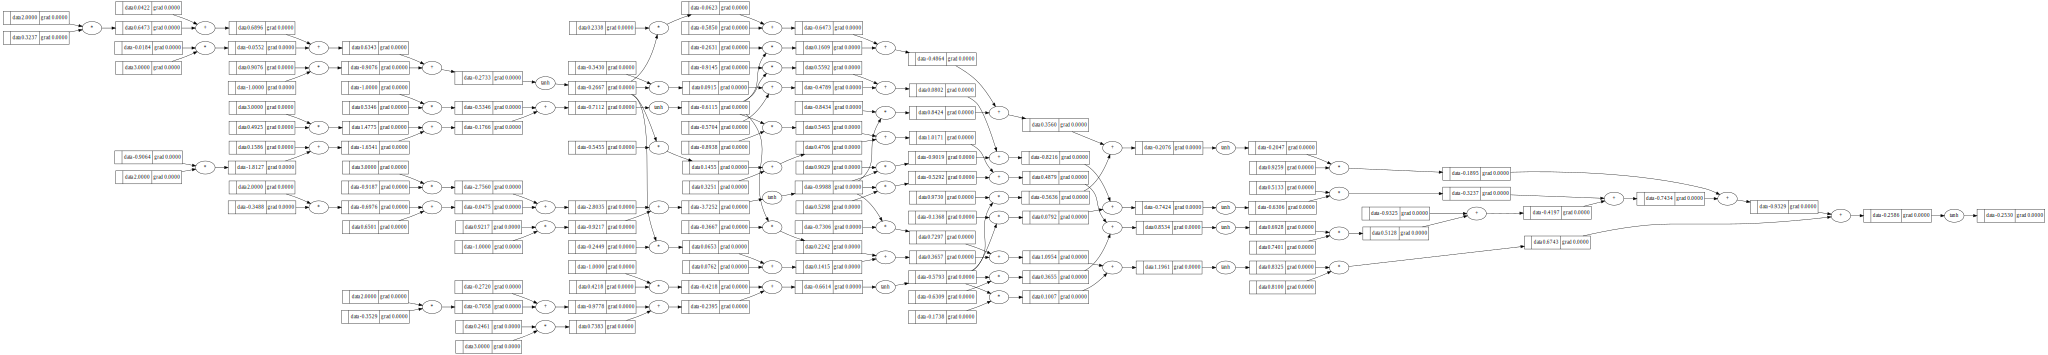

In [ ]:
# draw_dot(n(x))

# dataset

In [ ]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]
ys = [1.0, -1.0, -4.0, 1.0]   #desired targets

# Training our network manually
basically iterating the loss function, backpropegation and checking the prediction over and over again




In [ ]:
#finding loss i.e. MSE
#first loss
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss

value(data=21.2146507785129)

In [ ]:
loss.backward()

In [ ]:
#step 2
for p in n.parameters():
  p.data += -0.01 * p.grad    #gradient descent formula, 0.01 is the learning rate/step size

In [ ]:
#step 3
ypred = [n(x) for x in xs]
# loss after doing backpropegation
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss

#iterated a few times and yes loss is in fact decreasing.

value(data=17.553280236077846)

In [ ]:
# step 4
ypred

[value(data=-0.9362058933149117),
 value(data=-0.6416953217602093),
 value(data=-0.8395251446722751),
 value(data=-0.9202612898153023)]

In [ ]:
n.parameters()

[value(data=0.12323516685774395),
 value(data=-0.5344049880974021),
 value(data=1.2016279281351074),
 value(data=-0.10482453797679332),
 value(data=-2.233300984528353),
 value(data=-1.2828650182829269),
 value(data=1.4988749210103753),
 value(data=-0.6724907909468458),
 value(data=0.14438434760068672),
 value(data=-1.0740084239468666),
 value(data=1.142845397152907),
 value(data=0.8394413477031963),
 value(data=0.5988585580765302),
 value(data=1.4167465225672822),
 value(data=-0.13922690398667728),
 value(data=0.3389483053784763),
 value(data=-0.8443395176059749),
 value(data=-1.154941798784245),
 value(data=-0.07533183689407247),
 value(data=-0.9469386786972774),
 value(data=0.7479765990603049),
 value(data=-0.6784347306895868),
 value(data=-1.257261949385922),
 value(data=0.24393212975264317),
 value(data=-0.4357125466198089),
 value(data=-0.01657109211670159),
 value(data=-0.49393215323482875),
 value(data=-1.0877506401448835),
 value(data=-2.3765285044006483),
 value(data=0.1544582

# creating loop to iterate automatically

In [ ]:
for k in range(30):     #epoch
  #forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

  # backpropegation
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()

  # update parameters
  for p in n.parameters():
    p.data += -0.7 * p.grad

  print(k, loss.data)

0 9.001837824747867
1 9.00179924768686
2 9.0017622503776
3 9.001726737762649
4 9.0016926222635
5 9.001659823058906
6 9.001628265445182
7 9.001597880267887
8 9.001568603415743
9 9.001540375368961
10 9.001513140795277
11 9.00148684818792
12 9.001461449540523
13 9.001436900054628
14 9.00141315787606
15 9.00139018385689
16 9.001367941340128
17 9.001346395964653
18 9.001325515488203
19 9.001305269626494
20 9.001285629906794
21 9.00126656953442
22 9.001248063270909
23 9.001230087322634
24 9.00121261923884
25 9.001195637818233
26 9.001179123023233
27 9.001163055901191
28 9.001147418511959
29 9.001132193861135


In [ ]:
ypred

[value(data=0.9919290311047224),
 value(data=-0.9997116796112318),
 value(data=-0.9998303819876173),
 value(data=0.9929833520101456)]